<a href="https://colab.research.google.com/github/MengOonLee/LLM/blob/main/References/LangChain/ipynb/T10_Local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash

pip install --no-cache-dir -qU \
    torch torchvision lightning transformers accelerate \
    langchain langgraph langchain-core langchain-community \
    langchain-huggingface huggingface_hub

In [ ]:
!hf auth login

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")
import transformers
import time

model_name = "google/gemma-3-1b-it"
local_path = "./models"
os.makedirs(local_path, exist_ok=True)

start_time = time.time()
model = transformers.AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_name)
model.save_pretrained(save_directory=local_path)
tokenizer = transformers.AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path=model_name)
tokenizer.save_pretrained(save_directory=local_path)
end_time = time.time() - start_time

print("Time taken: %.2f"%(end_time))

In [ ]:
import transformers
from langchain_huggingface import llms

model = transformers.AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=local_path)
tokenizer = transformers.AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path=local_path)

pipe = transformers.pipeline(model=model, tokenizer=tokenizer,
    task="text-generation")
llm = llms.HuggingFacePipeline(pipeline=pipe)

In [ ]:
from langchain_core import prompts
import time

template = """
Question: {question}
"""
prompt = prompts.PromptTemplate.from_template(template)

chain = prompt | llm

question = "What is SWIFT financial messaging?"

start_time = time.time()
response = chain.invoke(input={"question": question})
end_time = time.time() - start_time

print("Time take: %.4f, %s"%(end_time, response))

Time take: 94.9742, 
Question: What is SWIFT financial messaging?
**Answer:** SWIFT (Society for Worldwide Interbank Financial Telecommunication) is a global financial messaging network that facilitates the transfer of funds between banks.
**Additional information:** SWIFT is a crucial component of the international payments system.
**Explanation:** SWIFT is a secure, private network that allows banks around the world to communicate about payments. It's used to send money, transfer accounts, and process transactions across borders.

Would you like me to provide more details about SWIFT?



In [8]:
from langchain_core import prompts
import time

review_template = """
For the following text, extract the following information:

gift: Was the item purchased as a gift for someone else?
Answer True if yes, False if not or unknown.

delivery_days: How many days did it take for the product
to arrive? If this information is not found, output -1.

price_value: Extract any sentences about the value or price,
and output them as a comma separated Python list.

Format the output as JSON with the following keys:
gift
delivery_days
price_value

text: {text}
"""

prompt_template = prompts.ChatPromptTemplate.from_template(
    template=review_template
)

customer_review = """
This leaf blower is pretty amazing.  It has four settings:
candle blower, gentle breeze, windy city, and tornado. It
arrived in two days, just in time for my wife's anniversary
present. I think my wife liked it so much she was speechless. So
far I've been the only one using it, and I've been using it
every other morning to clear the leaves on our lawn. It's
slightly more expensive than the other leaf blowers out there,
but I think it's worth it for the extra features.
"""

review_messages = prompt_template.format_messages(
    text=customer_review
)

start_time = time.time()
review_response = llm.invoke(input=review_messages)
end_time = time.time() - start_time
print("Duration: %.2f, Response: %s"%(end_time, review_response))

Duration: 145.40, Response: Human: 
For the following text, extract the following information:

gift: Was the item purchased as a gift for someone else?
Answer True if yes, False if not or unknown.

delivery_days: How many days did it take for the product
to arrive? If this information is not found, output -1.

price_value: Extract any sentences about the value or price,
and output them as a comma separated Python list.

Format the output as JSON with the following keys:
gift
delivery_days
price_value

text: 
This leaf blower is pretty amazing.  It has four settings:
candle blower, gentle breeze, windy city, and tornado. It
arrived in two days, just in time for my wife's anniversary
present. I think my wife liked it so much she was speechless. So
far I've been the only one using it, and I've been using it
every other morning to clear the leaves on our lawn. It's
slightly more expensive than the other leaf blowers out there,
but I think it's worth it for the extra features.

```json
{
 

In [10]:
%%bash
pip install --no-cache-dir -qU wikipedia

In [11]:
from langchain import tools
import wikipedia
import typing

@tools.tool
def wikipedia_tool(
    query: typing.Annotated[str, """
        The Wikipedia search to execute to find key summary information.
    """]
):
    """
    Use this to search wikipedia for factual information.
    """
    try:
        results = wikipedia.search(query)
        if not results:
            return "No results."
        title = results[0]
        summary = wikipedia.summary(title, sentences=8, auto_suggest=False, redirect=True)
    except BaseException as e:
        return f"Error: {repl(e)}"
    return f"Wikipedia summary: {summary}"

company_name = "SWIFT Financial Messaging"
wikipedia_tool.invoke(input=f"{company_name}")

'Wikipedia summary: The Society for Worldwide Interbank Financial Telecommunication (SWIFT), legally S.W.I.F.T. SC, is a cooperative established in 1973 in Belgium (French: Société Coopérative) and owned by the banks and other member firms that use its service. SWIFT provides the main messaging network through which international payments are initiated. It also sells software and services to financial institutions, mostly for use on its proprietary "SWIFTNet", and assigns ISO 9362 Business Identifier Codes (BICs), popularly known as "SWIFT codes".\nAs of 2018, around half of all high-value cross-border payments worldwide used the SWIFT network, and in 2015, SWIFT linked more than 11,000 financial institutions in over 200 countries and territories, who were exchanging an average of over 32 million messages per day (compared to an average of 2.4 million daily messages in 1995).\nSWIFT is headquartered in La Hulpe near Brussels. It hosts an annual conference, called Sibos, specifically ai

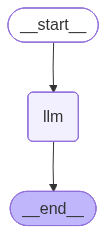

In [12]:
from typing_extensions import TypedDict
import typing
from langgraph import graph

class GraphState(TypedDict):
    messages: typing.Annotated[list, graph.message.add_messages]

workflow = graph.StateGraph(state_schema=GraphState)

def llm_node(state: GraphState):
    return {"messages": [llm.invoke(state["messages"])]}

workflow.add_node(node="llm", action=llm_node)

workflow.add_edge(start_key=graph.START, end_key="llm")
workflow.add_edge(start_key="llm", end_key=graph.END)
workflow = workflow.compile()
workflow

In [13]:
for chunk in workflow.stream(
    {"messages": [{
        "role": "user",
        "content": "Tell me about SWIFT ISO20022"
    }]}
):
    print(chunk)

{'llm': {'messages': ["Human: Tell me about SWIFT ISO20022.\n\nOkay, let's talk about SWIFT ISO20022.  It's a significant upgrade to the global financial messaging system.\n\nHere's a breakdown:\n\n*   **What it is:** SWIFT ISO20022 is a new protocol for exchanging payment instructions. It's designed to be a more secure, efficient, and reliable way to move money across borders.\n\n*   **How it works:**  It uses a standardized set of rules and a digital ledger to facilitate the exchange of payment instructions.  Think of it as a digital version of a traditional paper letter.\n\n*   **Key benefits:**\n    *   **Enhanced Security:**  It incorporates advanced security measures, like cryptographic signatures, to protect against fraud and cyberattacks.\n    *   **Increased Efficiency:**  It streamlines the process, reducing delays and costs.\n    *   **Improved Reliability:**  The standardized ledger and robust validation processes improve the accuracy and reliability of the data.\n    *   *